Initialise code for google colab

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa
print(tfa.__version__)

2.11.0
0.19.0


In [2]:
!pip install tensorflow==2.11
!pip install tensorflow-addons==0.19

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 117.0 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing 

Create data base files under google colab environment

In [3]:
!unzip -q '/content/drive/MyDrive/data_equalize.zip' -d '/content/'

For Luc because my archive made on mac create a __MACOSX folder

In [ ]:
%rm -rf /content/__MACOSX

Define working directory to our jupyter repertory:
* because path to the different repertories (./data, ./output...) are define relatevly to jupyter one
* let import _mypath which add ./lib to python path in order to import our own define libraries


In [1]:
%cd /content/drive/MyDrive/covid-19-xRay/jupyter


/content/drive/MyDrive/covid-19-xRay/jupyter


In [2]:
# for google colab use
from google.colab.patches import cv2_imshow
db_work_dir = '/content'


In [ ]:
# for local use
db_work_dir = '..'

In [2]:
import _mypath
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 1



ModuleNotFoundError: ignored

In [31]:
%aimport database.path_origin_data
%aimport database.dataset

from database.path_origin_data import build_data_paths 
from database.path_origin_data import lung_name, infection_name
from database.path_origin_data import train_name, test_name, valid_name
from database.path_origin_data import normal_name, covid_name, no_covid_name
from database.path_origin_data import images_name, lung_mask_name, infection_mask_name

from database.dataset import build_dataset

%aimport run_exp.test
%aimport run_exp.classif_autoencoder
%aimport run_exp.standard

from run_exp.test import compile_test_model, test_accuracy, test_conf_mat
from run_exp.classif_autoencoder import run_experiment as run_experiment_autoencoder
from run_exp.standard import run_experiment as run_experiment_pure_cnn



Build paths and variables for reading data base hierarchy

In [5]:
# input
db_name = 'data_equalize'
db_path = os.path.join(db_work_dir, db_name)

# output
output_path = os.path.join('..', 'output')
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)

ckpt_path = os.path.join(output_path, 'ckpt')
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path, exist_ok=True)


Structure to manage paths in data base

In [6]:
data_paths = build_data_paths()
idx = pd.IndexSlice

Create tf Dataset

In [7]:

paths = data_paths['path']

ds_train = build_dataset(db_path, paths, db=[lung_name], ds=[train_name])
ds_test = build_dataset(db_path, paths, db=[lung_name], ds=[test_name])
ds_valid = build_dataset(db_path, paths, db=[lung_name], ds=[valid_name])
ds_train


Found 6849 files belonging to 1 classes.
Found 7658 files belonging to 1 classes.
Found 7208 files belonging to 1 classes.
Found 2140 files belonging to 1 classes.
Found 2394 files belonging to 1 classes.
Found 2253 files belonging to 1 classes.
Found 1712 files belonging to 1 classes.
Found 1902 files belonging to 1 classes.
Found 1802 files belonging to 1 classes.


<ConcatenateDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.int32, name=None))>

Model parameters

In [8]:
batch_size_cnn = 32
batch_size_transformer = 32

image_size = 256
input_shape = (image_size, image_size, 1)

learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100

label_smoothing = 0.1
lam_recon = 10.
patience = 5
min_delta = 0.005
min_delta_fine_tuning = 0.0005

# data augmentation
scale = 1. / 255.
flip = "horizontal"
rotation_factor = 10. / 360.
zoom_height_factor = 0.2
zoom_width_factor = 0.2

# vit
patch_size = 1
transformer_layers = 4
num_heads = 8
projection_dim = 64
transformer_units_rate = [2, 1]
mlp_head_units = [1024, 256]  # Size of the dense layers of the final classifier


Data augmentation

In [9]:
augmentation = keras.Sequential(
    [
      layers.Rescaling(scale=scale),
      layers.RandomFlip(flip),
      layers.RandomRotation(rotation_factor),
      layers.RandomZoom(height_factor=zoom_height_factor, width_factor=zoom_width_factor),
    ],
    name='augmentation'
)

cnn encoder

In [10]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout

encoder = keras.Sequential(
    [
      layers.Conv2D(128, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(128, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      # layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      # layers.MaxPooling2D(pool_size = (2, 2)),
      # layers.Conv2D(32, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.Flatten(),
    ],
    name='encoder'
)

decoder

In [11]:
decoder = keras.Sequential(
    [
      layers.Dense(1024, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(np.prod(input_shape), activation='sigmoid'),
      layers.Reshape(target_shape=input_shape),
    ],
    name='decoder'
)


In [12]:
classifier = keras.Sequential(
    [
      layers.Dense(1024, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(3, activation='softmax'),
    ],
    name='classifier'
)


In [13]:
class MyModel(tf.keras.Model):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.augmentation = augmentation
    self.encoder = encoder
    self.decoder = decoder
    self.classifier = classifier

  def call(self, inputs):
    x = self.augmentation(inputs)
    x = self.encoder(x)
    self.decoder(x)
    return self.classifier(x)

classif_decoder = MyModel(name='classif_decoder')

inputs = layers.Input(shape=input_shape)
classified_decoded = classif_decoder(inputs)

model = keras.Model(inputs=inputs, outputs=classified_decoded)
model.get_layer('classif_decoder').summary()



Model: "classif_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (None, 256, 256, 1)       0         
                                                                 
 encoder (Sequential)        (None, 4096)              296512    
                                                                 
 decoder (Sequential)        (None, 256, 256, 1)       21300480  
                                                                 
 classifier (Sequential)     (None, 3)                 4458499   
                                                                 
Total params: 26,055,491
Trainable params: 26,055,491
Non-trainable params: 0
_________________________________________________________________


In [ ]:
classif_decoder = model.get_layer('classif_decoder')
encoder_input = classif_decoder.get_layer('augmentation')
decoder_output = classif_decoder.get_layer('decoder')

cnn_history, cnn_conf_mat = run_experiment_autoencoder(
    model, encoder_input, decoder_output,
    ds_train, ds_valid, ds_test,
    batch_size=batch_size_cnn, num_epochs=num_epochs,
    learning_rate=learning_rate, weight_decay=weight_decay,
    lam_recon=lam_recon,
    from_logits=False, label_smoothing=label_smoothing,
    patience=patience, min_delta=min_delta,
    output_path=output_path, prefix='cnn'
)


In [18]:
import joblib

file_name = os.path.join(output_path, 'cnn_conf_mat.joblib')
joblib.dump(cnn_conf_mat, file_name)

cnn_conf_mat

Predicted,0,1,2
Real,,,
0,1975,32,133
1,40,2298,56
2,136,46,2071


In [14]:
checkpoint_filename = os.path.join(ckpt_path, 'cnn_weights.hdf5')
model.load_weights(checkpoint_filename)


In [15]:
cnn_conf_mat = compile_test_model(
    model,
    ds_test, batch_size_cnn,
    from_logits=False, label_smoothing=label_smoothing
)
cnn_conf_mat

213/213 [==============================] - 16s 53ms/step - loss: 0.4266 - accuracy: 0.9347
Test accuracy: 93.47%
213/213 [==============================] - 11s 49ms/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Predicted,0,1,2
Real,,,
0,1975,32,133
1,40,2298,56
2,136,46,2071


Fine tuning cnn without decoder part

In [14]:
inputs = layers.Input(shape=input_shape)
augmented = augmentation(inputs)
encoded = encoder(augmented)
classified = classifier(encoded)


In [15]:
# Create the Keras model.
model_pure_cnn = keras.Model(inputs=inputs, outputs=classified)
model_pure_cnn.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 augmentation (Sequential)   (None, 256, 256, 1)       0         
                                                                 
 encoder (Sequential)        (None, 4096)              296512    
                                                                 
 classifier (Sequential)     (None, 3)                 4458499   
                                                                 
Total params: 4,755,011
Trainable params: 4,755,011
Non-trainable params: 0
_________________________________________________________________


In [17]:
pure_cnn_history, pure_cnn_conf_mat = run_experiment_pure_cnn(
    model_pure_cnn,
    ds_train, ds_valid, ds_test,
    batch_size=batch_size_cnn, num_epochs=num_epochs,
    learning_rate=learning_rate / 1000., weight_decay=weight_decay,
    from_logits=False, label_smoothing=label_smoothing,
    patience=patience, min_delta=min_delta_fine_tuning,
    output_path=output_path, prefix='pure_cnn_lr0.001'
)


Epoch 1/100


679/679 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.8982
Epoch 1: val_accuracy improved from -inf to 0.91876, saving model to ../output/ckpt/pure_cnn_lr0.001_weights.hdf5
679/679 [==============================] - 252s 311ms/step - loss: 0.4813 - accuracy: 0.8982 - val_loss: 0.4737 - val_accuracy: 0.9188
Epoch 2/100
679/679 [==============================] - ETA: 0s - loss: 0.5301 - accuracy: 0.8971
Epoch 2: val_accuracy did not improve from 0.91876
679/679 [==============================] - 225s 302ms/step - loss: 0.5301 - accuracy: 0.8971 - val_loss: 0.5298 - val_accuracy: 0.9165
Epoch 3/100
679/679 [==============================] - ETA: 0s - loss: 0.5960 - accuracy: 0.8878
Epoch 3: val_accuracy did not improve from 0.91876
679/679 [==============================] - 223s 302ms/step - loss: 0.5960 - accuracy: 0.8878 - val_loss: 0.5948 - val_accuracy: 0.9141
Epoch 4/100
679/679 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.8730
Epo

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
import joblib

file_name = os.path.join(output_path, 'pure_cnn_lr0.001_conf_mat.joblib')
joblib.dump(pure_cnn_conf_mat, file_name)

pure_cnn_conf_mat

Predicted,0,1,2
Real,,,
0,1988,21,131
1,59,2259,76
2,129,38,2086


In [16]:
checkpoint_filename = os.path.join(ckpt_path, 'pure_cnn_lr0.001_weights.hdf5')
model_pure_cnn.load_weights(checkpoint_filename)


In [20]:
pure_cnn_conf_mat = compile_test_model(
    model_pure_cnn,
    ds_test, batch_size_cnn,
    from_logits=False, label_smoothing=label_smoothing
)
pure_cnn_conf_mat

213/213 [==============================] - 12s 51ms/step - loss: 0.4612 - accuracy: 0.9331
Test accuracy: 93.31%
213/213 [==============================] - 12s 50ms/step


Predicted,0,1,2
Real,,,
0,1988,21,131
1,59,2259,76
2,129,38,2086


Branch transformer on top of cnn.

In [21]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0   

In [12]:
# Sub Model
shared_encoder = keras.Sequential(name='shared_encoder')

for layer in encoder.layers[:-1]:
  shared_encoder.add(layer)

for layer in shared_encoder.layers:
  layer.trainable = False


In [13]:

%aimport myLayers.vision_transformer
%aimport myLayers.mlp
from myLayers.vision_transformer import add_vit
from myLayers.mlp import mlp

inputs = layers.Input(shape=input_shape)
augmented_transformer = augmentation(inputs)
shared_model = shared_encoder(augmented_transformer)
features = add_vit(shared_model,
            patch_size=patch_size,
            input_image_size=shared_model.shape[1],
            transformer_layers=transformer_layers,
            num_heads=num_heads,
            projection_dim=projection_dim,
            transformer_units_rate=transformer_units_rate,
            mlp_head_units=mlp_head_units)
# Classify outputs.
softmax = layers.Dense(3, activation='softmax', kernel_initializer='random_normal')(features)

# Create the Keras model
model_transformer = keras.Model(inputs=inputs, outputs=softmax)
shared_encoder.summary()
model_transformer.summary()


Model: "shared_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)    

In [19]:
%aimport run_exp.standard
from run_exp.standard import run_experiment as run_experiment_transformer

transformer_history, transformer_conf_mat = run_experiment_transformer(
    model_transformer,
    ds_train, ds_valid, ds_test,
    batch_size=batch_size_transformer, num_epochs=num_epochs,
    learning_rate=learning_rate / 2., weight_decay=weight_decay,
    from_logits=False, label_smoothing=label_smoothing,
    patience=patience, min_delta=min_delta,
    output_path=output_path, prefix='transformer_8_8_lr0.5'
)


Epoch 1/100


679/679 [==============================] - ETA: 0s - loss: 0.9223 - accuracy: 0.6175
Epoch 1: val_accuracy improved from -inf to 0.68796, saving model to ../output/ckpt/transformer_8_8_lr0.5_weights.hdf5
679/679 [==============================] - 199s 247ms/step - loss: 0.9223 - accuracy: 0.6175 - val_loss: 0.8249 - val_accuracy: 0.6880
Epoch 2/100
679/679 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.7835
Epoch 2: val_accuracy improved from 0.68796 to 0.71104, saving model to ../output/ckpt/transformer_8_8_lr0.5_weights.hdf5
679/679 [==============================] - 182s 244ms/step - loss: 0.6964 - accuracy: 0.7835 - val_loss: 0.8053 - val_accuracy: 0.7110
Epoch 3/100
679/679 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.8029
Epoch 3: val_accuracy improved from 0.71104 to 0.71806, saving model to ../output/ckpt/transformer_8_8_lr0.5_weights.hdf5
679/679 [==============================] - 183s 246ms/step - loss: 0.6559 - accuracy: 0.

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [20]:
import joblib

file_name = os.path.join(output_path, 'transformer_8_8_lr0.5_conf_mat.joblib')
joblib.dump(transformer_conf_mat, file_name)

transformer_conf_mat

Predicted,0,1,2
Real,,,
0,1791,220,129
1,418,1679,297
2,207,210,1836


In [20]:
checkpoint_filename = os.path.join(ckpt_path, 'transformer_8_8_lr0.5_all_layers_lr_weights.hdf5')
model_transformer.load_weights(checkpoint_filename)


In [14]:
transformer_conf_mat = compile_test_model(
    model_transformer,
    ds_test, batch_size_transformer,
    from_logits=False, label_smoothing=label_smoothing
)
transformer_conf_mat

213/213 [==============================] - 26s 72ms/step - loss: 0.4304 - accuracy: 0.9262
Test accuracy: 92.62%
213/213 [==============================] - 14s 59ms/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Predicted,0,1,2
Real,,,
0,2030,13,97
1,69,2234,91
2,213,18,2022


In [14]:
for layer in shared_encoder.layers:
  layer.trainable = True

In [ ]:
%aimport run_exp.standard
from run_exp.standard import run_experiment as run_experiment_transformer

transformer_fine_tuning_history, transformer_fine_tuning_conf_mat = run_experiment_transformer(
    model_transformer,
    ds_train, ds_valid, ds_test,
    batch_size=batch_size_transformer, num_epochs=num_epochs,
    learning_rate=learning_rate / 10000., weight_decay=weight_decay,
    from_logits=False, label_smoothing=label_smoothing,
    patience=patience, min_delta=min_delta_fine_tuning,
    output_path=output_path, prefix='transformer_8_8_lr0.5_all_layers_lr_fine_tuning_lr0.0001'
)


In [21]:
import joblib

file_name = os.path.join(output_path, 'transformer_8_8_lr0.5_all_layers_lr_fine_tuning_lr0.0001_conf_mat.joblib')
joblib.dump(transformer_fine_tuning_conf_mat, file_name)

transformer_fine_tuning_conf_mat

Predicted,0,1,2
Real,,,
0,1896,24,220
1,32,2294,68
2,86,32,2135


In [43]:
checkpoint_filename = os.path.join(ckpt_path, 'transformer_8_8_lr0.5_all_layers_lr_fine_tuning_lr0.0001_weights.hdf5')
model_transformer.load_weights(checkpoint_filename)


In [44]:
# test_accuracy(
#     model_transformer,
#     ds_train, batch_size_transformer,
# )
# test_accuracy(
#     model_transformer,
#     ds_valid, batch_size_transformer,
# )
# test_accuracy(
#     model_transformer,
#     ds_test, batch_size_transformer,
# )

transformer_fine_tuning_conf_mat = compile_test_model(
    model_transformer,
    ds_test, batch_size_transformer,
    from_logits=False, label_smoothing=label_smoothing
)
transformer_fine_tuning_conf_mat

213/213 [==============================] - 14s 61ms/step - loss: 0.4454 - accuracy: 0.9334
Test accuracy: 93.34%
213/213 [==============================] - 14s 59ms/step


Predicted,0,1,2
Real,,,
0,1907,23,210
1,32,2294,68
2,87,32,2134


In [45]:
def extract_conv_model(model, layer_index, encoder_name='shared_encoder'):
  encoder_index = 0
  for i, layer in enumerate(model.layers):
    if layer.name == encoder_name:
      encoder_index = i
      break
  # print(encoder_index)

  pre_model = keras.Model(model.input, model.layers[encoder_index-1].get_output_at(0))
  eff_net = keras.Model(model.layers[encoder_index].layers[0].input, model.layers[encoder_index].layers[layer_index].get_output_at(0))
  until_conv_model = keras.Model(pre_model.input, eff_net.call(pre_model.output))
  return until_conv_model

encoder_name = 'shared_encoder'
model_transformer.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 augmentation (Sequential)      (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 shared_encoder (Sequential)    (None, 8, 8, 64)     296512      ['augmentation[0][0]']           
                                                                                                  
 patches (Patches)              (None, None, 64)     0           ['shared_encoder[0][0]']     

In [46]:
path = data_paths['path'].loc[idx[[lung_name], [test_name], [normal_name], [images_name]]][0]
image_path = os.path.join(db_path, path)
list_file_name_normal = os.listdir(image_path)
list_file_name_normal = [os.path.join(image_path, file_name) for file_name in list_file_name_normal]

path = data_paths['path'].loc[idx[[lung_name], [test_name], [covid_name], [images_name]]][0]
image_path = os.path.join(db_path, path)
list_file_name_covid = os.listdir(image_path)
list_file_name_covid = [os.path.join(image_path, file_name) for file_name in list_file_name_covid]

path = data_paths['path'].loc[idx[[lung_name], [test_name], [no_covid_name], [images_name]]][0]
image_path = os.path.join(db_path, path)
list_file_name_no_covid = os.listdir(image_path)
list_file_name_no_covid = [os.path.join(image_path, file_name) for file_name in list_file_name_no_covid]

list_file_name = list_file_name_covid


In [47]:
image_file_name = list_file_name[100]
image_file_name

'/content/data_equalize/Lung Segmentation Data/Test/COVID-19/images/covid_374.png'

In [52]:
model_shared_encoder_4 = extract_conv_model(model_transformer, 4, encoder_name=encoder_name)


In [53]:

# Load image
img = keras.preprocessing.image.load_img(
    image_file_name,
    target_size=(image_size, image_size),
    grayscale=True)
img = keras.preprocessing.image.img_to_array(img)

# Get the outputs of layers we want to inspect
outputs = [model_shared_encoder_4.output]

# Create a connection between the input and those target outputs
activations_model = keras.Model(model_transformer.input, outputs=outputs)
activations_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Get their outputs
activations = activations_model.predict(np.array([img]))

/usr/local/lib/python3.8/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 172ms/step


In [54]:
activations.shape

(1, 64, 64, 64)

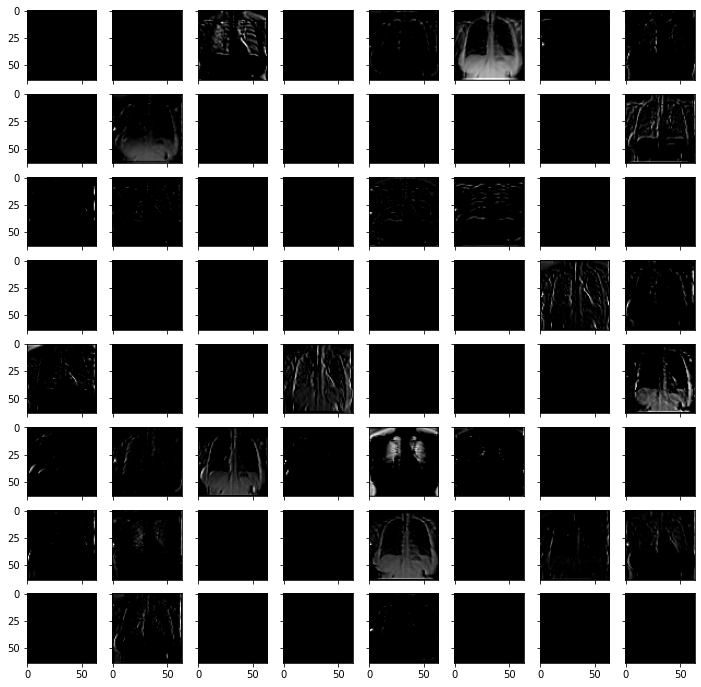

In [55]:
nrows = 8
ncols = 8
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12, 12))
num_filer = min(nrows*ncols, activations.shape[-1])
for i in range(num_filer):
    image = activations[0, :, :, i]   
    ax.flatten()[i].imshow(image, cmap='gray')

plt.savefig(os.path.join(output_path, 'activation_conv_layer_4.png'), format='png')
plt.show()


In [56]:
def build_pattern(submodel, pattern_size, filter_index, epochs, step_size):
  # Initiate random noise
  input_img_data = np.random.random((1, pattern_size, pattern_size, 1))
  input_img_data = (input_img_data - 0.5) * 5 + 128.
  # input_img_data = 128. * np.ones((1, pattern_size, pattern_size, 1))

  # Cast random noise from np.float64 to tf.float32 Variable
  input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

  # Iterate gradient ascents
  for _ in range(epochs):
      with tf.GradientTape() as tape:
          outputs = submodel(input_img_data, training=False)
          loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
      grads = tape.gradient(loss_value, input_img_data)
      normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
      input_img_data.assign_add(normalized_grads * step_size)

  return input_img_data[0]

def build_pattern_list(submodel, pattern_size, nb_filter, epochs=100, step_size=1.):
  pattern_list = []
  for i in range(nb_filter):
    pattern_list.append(build_pattern(submodel, pattern_size, i, epochs, step_size))
  
  return pattern_list


In [66]:
conv_layers = tf.keras.Sequential(name='conv_layer')
conv_layer_index = 2
nb_filters = 128 # 64
pattern_size = 5 # 11

for layer in shared_encoder.layers[:conv_layer_index]:
  conv_layers.add(layer)


inputs_pattern_size = layers.Input(shape=(pattern_size, pattern_size, 1))
augmented_input_pattern_size = augmentation(inputs_pattern_size)
conv_layers_input_pattern_size = conv_layers(augmented_input_pattern_size)

model_conv_layers_input_pattern_size = keras.Model(
    inputs=inputs_pattern_size,
    outputs=conv_layers_input_pattern_size
)


In [67]:
epochs = 100
step_size = 1.

# Create a connection between the input and the target layer
submodel = model_conv_layers_input_pattern_size

pattern_list = build_pattern_list(submodel, pattern_size, nb_filters, epochs=epochs, step_size=step_size)


In [1]:
nrows = 8
ncols = 16
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12, 12))
num_filer = min(nrows*ncols, len(pattern_list))
for i in range(num_filer):
    image = pattern_list[i]
    ax.flatten()[i].imshow(np.squeeze(image), cmap='gray')

plt.savefig(os.path.join(output_path, 'pattern_conv_layer_2.png'), format='png')
plt.show()


NameError: ignored

In [ ]:
# Create function to apply a grey patch on an image
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 127.5

    return patched_image

def occultation(img, model, patch_size=32, sub_samp_for_step=4, pred_index=None):
    sensitivity_map = np.zeros((img.shape[0], img.shape[1]))
    count_map = np.zeros((img.shape[0], img.shape[1]))

    # Iterate the patch over the image
    for top_left_x in range(0, img.shape[0], patch_size // sub_samp_for_step):
        for top_left_y in range(0, img.shape[1], patch_size // sub_samp_for_step):
            patched_image = apply_grey_patch(img, top_left_x, top_left_y, patch_size)
            predictions = model.predict(np.array([patched_image]), verbose=(top_left_y == 0))[0]
            if pred_index is None:
                pred_index = tf.argmax(predictions)
            confidence = predictions[pred_index]
            
            # Save confidence for this specific patched image in map
            sensitivity_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] \
            = (sensitivity_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] \
            * count_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] \
            + confidence) \
            / (count_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] + 1)

            count_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] += 1

    return sensitivity_map


In [ ]:
# Load image
img = keras.preprocessing.image.load_img(
    image_file_name,
    target_size=(image_size, image_size),
    grayscale=True)
img = keras.preprocessing.image.img_to_array(img)
img.shape

sensitivity_map = occultation(img, model_transformer, patch_size=32, sub_samp_for_step=4, pred_index=None)


1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.8/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


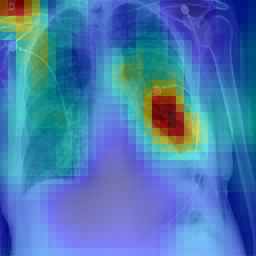

True

In [ ]:
# sensitivity_map.min()
heatmap = 1. - (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min())
sens = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, sens, 0.5, 0)

cv2_imshow(output_image)
cv2.imwrite(os.path.join(output_path, 'occultation.png'), output_image)


In [ ]:
image_file_name = list_file_name[754]
image_file_name = list_file_name[1700]
image_file_name

'../data_equalize/Lung Segmentation Data/Train/COVID-19/images/sub-S10281_ses-E17796_run-1_bp-chest_vp-ap_cr.png'

In [ ]:
def grad_cam(img, grad_model, resize_shape=None, pred_index=None):
  image_size = img.shape[0]

  with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]), training=False)
    if pred_index is None:
      pred_index = tf.argmax(predictions[0])
    loss = predictions[:, pred_index]
  
  output = conv_outputs[0]
  grads = tape.gradient(loss, conv_outputs)[0]

  gate_f = tf.cast(output > 0, 'float32')
  gate_r = tf.cast(grads > 0, 'float32')
  guided_grads = gate_f * gate_r * grads

  weights = tf.math.multiply(guided_grads, output)
  cam = tf.reduce_sum(weights, axis=-1).numpy()

  # if resize_shape is None:
  #     weights = tf.reduce_mean(guided_grads, axis=(0, 1))
  # else:
  #     weights = tf.reduce_mean(guided_grads, axis=(0,))
  # cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1).numpy()

  if resize_shape is not None:
      cam = cam.reshape(resize_shape)

  cam = cv2.resize(cam, (image_size, image_size))
  cam = np.maximum(cam, 0)
  # heatmap = (cam - cam.min()) / (cam.max() - cam.min())
  heatmap = cam / cam.max()

  cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  cam = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 0.5, 0)

  return cam

def grad_cam_list(file_name_list, grad_model, resize_shape=None, pred_index=None):
  cam_list = []

  for file_name in file_name_list:
    img = keras.preprocessing.image.load_img(
      file_name,
      target_size=(image_size, image_size),
      color_mode = "grayscale")
    img = keras.preprocessing.image.img_to_array(img)

    cam = grad_cam(img, grad_model, resize_shape=resize_shape, pred_index=None)
    cam_list.append(cam)

  return cam_list


In [ ]:
from random import sample

list_file_name = list_file_name_covid
title = 'Grad_CAM_covid'

nrows = 8
ncols = 8
num_img = nrows * ncols

samples = list_file_name
if (len(samples) >= num_img):
  samples = sample(samples, num_img)

# output_conv_layer = model_transformer.get_layer(encoder_name).get_output_at(0)
# resize_shape = None
output_conv_layer = model_transformer.get_layer('layer_normalization_17').get_output_at(0)
resize_shape = (8, 8)

grad_model = keras.Model(
  [model_transformer.input],
  [output_conv_layer, model_transformer.output])

cam_list = grad_cam_list(samples, grad_model, resize_shape=resize_shape, pred_index=None)


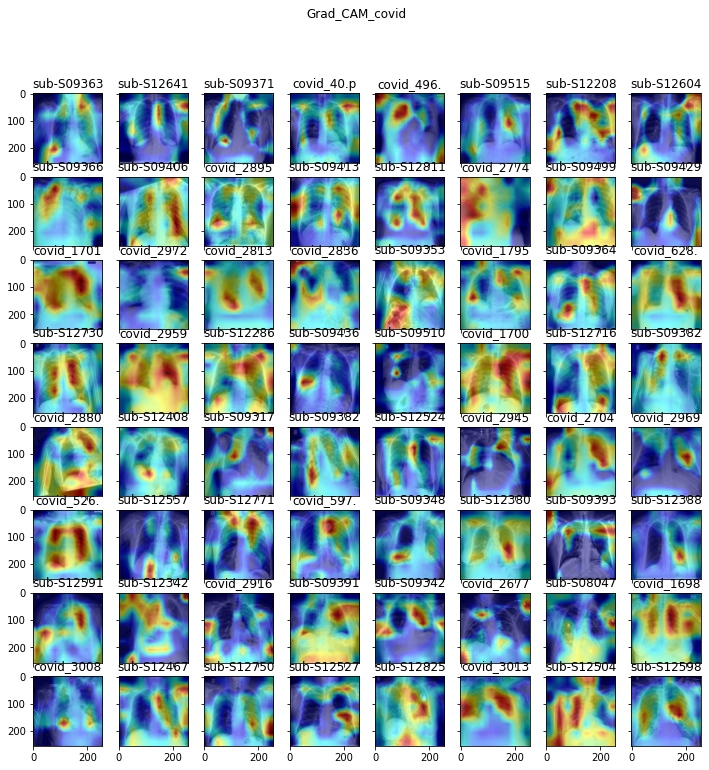

In [ ]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle(title)
ax = fig.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
for i, (cam, file_name) in enumerate(zip(cam_list, samples)):
  axe = ax.flatten()[i]

  img = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
  im_pil = Image.fromarray(img)

  axe.imshow(im_pil)
  f_name = os.path.basename(file_name)[:10]
  # print(f_name)
  axe.set_title(f_name)

plt.savefig(os.path.join(output_path , title + '.png'), format='png')
plt.show()
plt.close(fig)


In [ ]:
# Load image
print(image_file_name)
img = keras.preprocessing.image.load_img(
    image_file_name,
    target_size=(image_size, image_size),
    grayscale=True)
img = keras.preprocessing.image.img_to_array(img)

output_conv_layer = model_transformer.get_layer(encoder_name).get_output_at(0)
resize_shape = None
# output_conv_layer = model_transformer.get_layer('layer_normalization_8').get_output_at(0)
# resize_shape = (8, 8)

grad_model = keras.Model(
  [model_transformer.input],
  [output_conv_layer, model_transformer.output])

cam = grad_cam(img, grad_model, resize_shape=resize_shape, pred_index=None)


/content/data_equalize/Lung Segmentation Data/Test/COVID-19/images/sub-S12725_ses-E27111_run-1_bp-chest_vp-ap_cr.png


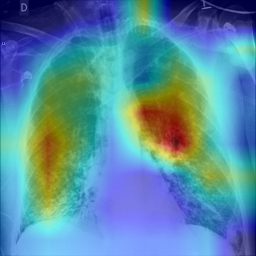

True

In [ ]:
output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 0.5, 0)

cv2_imshow(output_image)
cv2.imwrite(os.path.join(output_path, 'grad_cam.png'), output_image)
